# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5


---
__Name:__  Nicholas Chen   
__Class:__ MIDS w261 (Section Summer 2017, Group 1)     
__Email:__  nwchen24@iSchool.Berkeley.edu     
__Week:__   5

__Due Time:__ 2 Phases. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the AltaScale cluster and will be due Tuesday, Week 7 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. This will be a group exercise 


# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale   
DATSCIW261 ASSIGNMENT #5

Version 2017-9-2 


### IMPORTANT

This homework must be completed in the cloud 

### === INSTRUCTIONS for SUBMISSIONS ===   
Follow the instructions for submissions carefully.

Each student has a `HW-<user>` repository for all assignments.   

Click this link to enable you to create a github repo within the MIDS261 Classroom:   
https://classroom.github.com/assignment-invitations/3b1d6c8e58351209f9dd865537111ff8   
and follow the instructions to create a HW repo.

Push the following to your HW github repo into the master branch:
* Your local HW5 directory. Your repo file structure should look like this:

```
HW-<user>
    --HW3
       |__MIDS-W261-HW-03-<Student_id>.ipynb
       |__MIDS-W261-HW-03-<Student_id>.pdf
       |__some other hw3 file
    --HW4
       |__MIDS-W261-HW-04-<Student_id>.ipynb
       |__MIDS-W261-HW-04-<Student_id>.pdf
       |__some other hw4 file
    etc..
```    

<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="5.4"></a> 
# PHASE 2
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

### Job Configs  - Remove this Job Config File when Running on Altiscale

Save this job configs file to tell hadoop which python to use to execute mrjobs. See documentation here:  
http://mrjob.readthedocs.io/en/latest/guides/configs-basics.html#data-type-command  

Tried 
/opt/anaconda2/envs/py27/bin/python
/mnt/ephemeral1/jupyter/anaconda2/envs/py27/bin/python

In [6]:
!rm ~/.mrjob.conf

rm: cannot remove `/root/.mrjob.conf': No such file or directory


In [7]:
%%writefile /etc/mrjob.conf

runners:
    hadoop:
        python_bin: /opt/anaconda/bin/python

Overwriting /etc/mrjob.conf


### Write test datasets

In [8]:
import sys
sys.executable

'/opt/anaconda/bin/python'

In [9]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


In [10]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Writing atlas-boon-systems-test.txt


In [28]:
########################################################################
# Stripes for systems test 3 (given, no need to build stripes)
########################################################################

with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3   

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


### Stripes Systems Test

In [11]:
import collections as cl

test = cl.Counter()

In [12]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import collections as cl
import ast

class MRbuildStripes(MRJob):
  
    #START SUDENT CODE531_STRIPES
    
    #OUTPUT_PROTOCOL = JSONValueProtocol
    
    def steps(self):
        
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1',
            'mapreduce.job.reduces': '1'
        }
        
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer
                  )
        ]
    
    def mapper(self, _, line):
        
        #instantiate dict to hold stripes
        stripes_dict = {}
        
        #parse the co-occurrence count from the line
        co_occur_count = line.strip().split()[-3]

        #get pairs of words in the 5-gram and create a stripe for each unique word
        #Note the set here ensures that a word that appears more than once in a 5-gram won't be counted as co-occurring with itself
        #Note the permutations here will count both (word1,word2) and (word2,word1)
        for subset in itertools.permutations(sorted(set(line.strip().lower().split()[:-3])), 2):
            if subset[0] not in stripes_dict.keys():
                stripes_dict[subset[0]] = {}
                stripes_dict[subset[0]][subset[1]] = int(co_occur_count)
                
            elif subset[1] not in stripes_dict[subset[0]]:
                stripes_dict[subset[0]][subset[1]] = int(co_occur_count)
                
            else:
                stripes_dict[subset[0]][subset[1]] += int(co_occur_count)
        
        for key in stripes_dict:
            #yield key, json.dumps(stripes_dict[key])
            yield key, json.dumps(stripes_dict[key])

    def reducer_init(self):
        #instantiate placholder current key and counter
        self.placeholder_for_reducer = 0
        
    def reducer(self,key,stripe):
        
        #instantiate counter to hold combined stripes
        cur_counter = cl.Counter()
                
        for stripe_dict in stripe:
            cur_key = key
            
            #load the stripe into a dict
            stripe_dict_to_add = json.loads(stripe_dict)
            
            #update with each stripe
            cur_counter.update(stripe_dict_to_add)

        #output the key and the counter with the sum of all co-occurrences for that key
        yield key, cur_counter
        
        #The placeholder only increments when a new key is encountered
        #reducer seems to get chunks of key value pairs from the mapper with the same key all together
        self.placeholder_for_reducer += 1

    #END SUDENT CODE531_STRIPES

if __name__ == '__main__':
    MRbuildStripes.run()

Writing buildStripes.py


In [14]:
###########################################################################
# Make Stripes from ngrams for systems test 1
###########################################################################

!hdfs dfs -rm -r systems_test_stripes_1

#Local works
#!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1   

#Hadoop mode for docker container
!python buildStripes.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python buildStripes.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_stripes_1': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/buildStripes.root.20170616.204323.075321
Copying local files to hdfs:///user/root/tmp/mrjob/buildStripes.root.20170616.204323.075321/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob7059811283688301942.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0030
  Submitted application application_1497107873528_0030
  The url to track the job: http://

In [15]:
!cat systems_test_stripes_1

"a"	{"limited":55,"female":447,"general":92,"sea":62,"in":1201,"religious":59,"george":92,"biography":92,"city":62,"for":59,"tales":123,"government":102,"by":62,"forms":116,"wales":1099,"christmas":1099,"child's":1099,"collection":239,"the":124,"case":604,"circumstantial":62,"of":895,"study":604,"bill":59,"establishing":59,"narrative":62,"fairy":123}
"bill"	{"a":59,"religious":59,"for":59,"establishing":59}
"biography"	{"a":92,"of":92,"george":92,"general":92}
"by"	{"a":62,"city":62,"the":62,"sea":62}
"case"	{"a":604,"limited":55,"government":102,"of":502,"study":604,"female":447,"in":102}
"child's"	{"a":1099,"wales":1099,"christmas":1099,"in":1099}
"christmas"	{"a":1099,"wales":1099,"in":1099,"child's":1099}
"circumstantial"	{"a":62,"of":62,"the":62,"narrative":62}
"city"	{"a":62,"the":62,"by":62,"sea":62}
"collection"	{"a":239,"of":239,"fairy":123,"tales":123,"forms":116}
"establishing"	{"a":59,"bill":59,"religious":59,"for":59}
"fairy"	{"a":123,"of":123,"tales":123,"collection":123}

In [18]:
###########################################################################
# Make Stripes from ngrams for systems test 2
###########################################################################

!hdfs dfs -rm -r systems_test_stripes_2

#Local works
#!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1   

#Hadoop mode for docker container
!python buildStripes.py -r hadoop atlas-boon-systems-test.txt > systems_test_stripes_2   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python buildStripes.py -r hadoop atlas-boon-systems-test.txt > systems_test_stripes_2 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_stripes_2': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/buildStripes.root.20170616.204631.939732
Copying local files to hdfs:///user/root/tmp/mrjob/buildStripes.root.20170616.204631.939732/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob5304532271652937719.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0032
  Submitted application application_1497107873528_0032
  The url to track the job: http://

In [19]:
!cat systems_test_stripes_2

"atlas"	{"dipped":15,"boon":50}
"boon"	{"atlas":50,"dipped":10,"cava":10}
"cava"	{"dipped":10,"boon":10}
"dipped"	{"atlas":15,"boon":10,"cava":10}


### Inverted Index Systems Test

In [22]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections as cl
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class MRinvertedIndex(MRJob):
    #START SUDENT CODE531_INV_INDEX
    
    #OUTPUT_PROTOCOL = JSONValueProtocol

    
    def steps(self):
        
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1',
            'mapreduce.job.reduces': '1'
        }
        
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer
                  )
        ]
    
    def mapper(self, _, line):
        
        #Read the key and the stripe from the input
        key_stripe_list = line.translate(None,"\n").split("\t")
        
        key = json.loads(key_stripe_list[0])
        stripe = json.loads(key_stripe_list[1])
        
        #get length of the stripe
        stripe_len = len(stripe)
        
        #create dict that will hold doc title and the stripe length
        stripe_len_dict = {key:stripe_len}
        
        for term in stripe:
            yield term, stripe_len_dict
  
    def reducer(self, key, stripe):

        #instantiate a dict where we will combine stripe_len_dicts emitted from mapper
        stripe_len_dict_combined = {}
        
        #Read the incremental stripe length dit from the mapper output
        for stripe_len_dict in stripe:
            
            #update the dict above with each incremental stripe length dict
            stripe_len_dict_combined.update(stripe_len_dict)
                    
        yield key, stripe_len_dict_combined        
        
        #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Writing invertedIndex.py


In [23]:
###########################################################################
# Make Inverted Index from stripes in systems test 1
###########################################################################

!hdfs dfs -rm -r systems_test_inv_index_1

#Local works
#!python invertedIndex.py -r local systems_test_stripes_1 > systems_test_inv_index_1   

#Hadoop mode for docker container
!python invertedIndex.py -r hadoop systems_test_stripes_1 > systems_test_inv_index_1   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python invertedIndex.py -r hadoop systems_test_stripes_1 > systems_test_inv_index_1 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_inv_index_1': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/invertedIndex.root.20170616.212505.345512
Copying local files to hdfs:///user/root/tmp/mrjob/invertedIndex.root.20170616.212505.345512/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob1471530380974738148.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0034
  Submitted application application_1497107873528_0034
  The url to track the job: htt

In [24]:
!cat systems_test_inv_index_1

"a"	{"limited":4,"bill":4,"sea":4,"government":4,"collection":5,"general":4,"female":4,"in":7,"establishing":4,"religious":4,"by":4,"biography":4,"christmas":4,"case":7,"city":4,"circumstantial":4,"fairy":4,"for":4,"of":15,"tales":4,"child's":4,"george":4,"forms":3,"narrative":4,"wales":4,"the":7,"study":7}
"bill"	{"a":27,"religious":4,"for":4,"establishing":4}
"biography"	{"a":27,"of":15,"george":4,"general":4}
"by"	{"a":27,"city":4,"the":7,"sea":4}
"case"	{"a":27,"limited":4,"female":4,"in":7,"of":15,"study":7,"government":4}
"child's"	{"a":27,"wales":4,"christmas":4,"in":7}
"christmas"	{"a":27,"wales":4,"child's":4,"in":7}
"circumstantial"	{"a":27,"of":15,"the":7,"narrative":4}
"city"	{"a":27,"the":7,"by":4,"sea":4}
"collection"	{"a":27,"forms":3,"fairy":4,"tales":4,"of":15}
"establishing"	{"a":27,"bill":4,"religious":4,"for":4}
"fairy"	{"a":27,"of":15,"tales":4,"collection":5}
"female"	{"case":7,"of":15,"study":7,"a":27}
"for"	{"a":27,"bill":4,"religious":4,"establishing":4}
"forms

In [25]:
###########################################################################
# Make Inverted Index from stripes in systems test 2
###########################################################################

!hdfs dfs -rm -r systems_test_inv_index_2

#Local works
#!python invertedIndex.py -r local systems_test_stripes_2 > systems_test_inv_index_2   

#Hadoop mode for docker container
!python invertedIndex.py -r hadoop systems_test_stripes_2 > systems_test_inv_index_2   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python invertedIndex.py -r hadoop systems_test_stripes_2 > systems_test_inv_index_2 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_inv_index_2': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/invertedIndex.root.20170616.212609.534296
Copying local files to hdfs:///user/root/tmp/mrjob/invertedIndex.root.20170616.212609.534296/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob4350210489214509464.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0035
  Submitted application application_1497107873528_0035
  The url to track the job: htt

In [26]:
!cat systems_test_inv_index_2

"atlas"	{"dipped":3,"boon":3}
"boon"	{"atlas":2,"dipped":3,"cava":2}
"cava"	{"dipped":3,"boon":3}
"dipped"	{"atlas":2,"boon":3,"cava":2}


In [29]:
###########################################################################
# Make Inverted Index from stripes in systems test 3
###########################################################################

!hdfs dfs -rm -r systems_test_inv_index_3

#Local works
#!python invertedIndex.py -r local systems_test_stripes_3 > systems_test_inv_index_3   

#Hadoop mode for docker container
!python invertedIndex.py -r hadoop systems_test_stripes_3 > systems_test_inv_index_3   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python invertedIndex.py -r hadoop systems_test_stripes_3 > systems_test_inv_index_3 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_inv_index_3': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/invertedIndex.root.20170616.212854.887278
Copying local files to hdfs:///user/root/tmp/mrjob/invertedIndex.root.20170616.212854.887278/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob7061201187121360152.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0036
  Submitted application application_1497107873528_0036
  The url to track the job: htt

In [30]:
!cat systems_test_inv_index_3

"M"	{"DocC":4}
"N"	{"DocC":4}
"X"	{"DocB":2,"DocA":3}
"Y"	{"DocB":2,"DocC":4,"DocA":3}
"Z"	{"DocC":4,"DocA":3}


### Similarity Systems Test

In [31]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
  
    #START SUDENT CODE531_SIMILARITY
    #OUTPUT_PROTOCOL = JSONValueProtocol
    
    def steps(self):
        
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'stream.num.map.output.key.fields': '2',
            'mapreduce.partition.keycomparator.options': '-k1,1',
            'mapreduce.job.reduces': '1'
        }
        
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer
                  )
        ]
    
    def mapper(self, _, line):
        
        #Read the key and the stripe from the input
        key_index_list = line.translate(None,"\n").split("\t")
        
        key = json.loads(key_index_list[0])
        inv_index = json.loads(key_index_list[1])
        
        for subset in itertools.permutations(sorted(set(inv_index.keys())), 2):
            
            #get the lengths of each item that we want to output
            item_1_len = inv_index[subset[0]]
            item_2_len = inv_index[subset[1]]
            
            #create a two item dict to hold the item names and their lengths
            item_len_dict = {}
            item_len_dict[subset[0]] = item_1_len
            item_len_dict[subset[1]] = item_2_len
            
            #when output like this, can index with key[0] to get subset[0] in the reducer
            yield (subset[0], subset[1]), (1,item_len_dict)
  
    def reducer(self, key, stripe):

        #instantiate object to hold the number of times the terms / documents intersect
        items_intersect = 0
        cosine_sim_product = 0
        
        #the reducer gets output from the mapper in chunks grouped by key
        for n,item_len_dict in stripe:
            
            #get the length of item 1 and item 2
            item_1_len = item_len_dict[key[0]]
            item_2_len = item_len_dict[key[1]]
            
            #increment the intersect count
            items_intersect = items_intersect + n
            
            cosine_sim_product = cosine_sim_product + (1/np.sqrt(item_1_len)) * (1/np.sqrt(item_2_len))
            
        #calculate jacard similarity score
        jacard_sim_score = float(items_intersect)/ float(item_1_len + item_2_len - items_intersect)
        
        #Record cosine similarity score before moving on to the next chunk
        cosine_sim_score = cosine_sim_product
        
        yield key, (jacard_sim_score, cosine_sim_score)   
    
    #END SUDENT CODE531_SIMILARITY

if __name__ == '__main__':
    MRsimilarity.run()

Writing similarity.py


In [32]:
###########################################################################
# Document similarity from inverted index
###########################################################################

!hdfs dfs -rm -r systems_test_doc_similarity_1

#Local works
#!python similarity.py -r local systems_test_inv_index_1 > systems_test_doc_similarity_1   

#Hadoop mode for docker container
!python similarity.py -r hadoop systems_test_inv_index_1 > systems_test_doc_similarity_1   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python similarity.py -r hadoop systems_test_inv_index_1 > systems_test_inv_index_1 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_doc_similarity_1': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/similarity.root.20170616.213334.840861
Copying local files to hdfs:///user/root/tmp/mrjob/similarity.root.20170616.213334.840861/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob7089235033877818556.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0037
  Submitted application application_1497107873528_0037
  The url to track the job: http

In [33]:
!cat systems_test_doc_similarity_1

["a","bill"]	[0.1071428571,0.2886751346]
["a","biography"]	[0.1071428571,0.2886751346]
["a","by"]	[0.1071428571,0.2886751346]
["a","case"]	[0.2142857143,0.4364357805]
["a","child's"]	[0.1071428571,0.2886751346]
["a","christmas"]	[0.1071428571,0.2886751346]
["a","circumstantial"]	[0.1071428571,0.2886751346]
["a","city"]	[0.1071428571,0.2886751346]
["a","collection"]	[0.1428571429,0.3442651863]
["a","establishing"]	[0.1071428571,0.2886751346]
["a","fairy"]	[0.1071428571,0.2886751346]
["a","female"]	[0.1071428571,0.2886751346]
["a","for"]	[0.1071428571,0.2886751346]
["a","forms"]	[0.0714285714,0.2222222222]
["a","general"]	[0.1071428571,0.2886751346]
["a","george"]	[0.1071428571,0.2886751346]
["a","government"]	[0.1071428571,0.2886751346]
["a","in"]	[0.2142857143,0.4364357805]
["a","limited"]	[0.1071428571,0.2886751346]
["a","narrative"]	[0.1071428571,0.2886751346]
["a","of"]	[0.5,0.695665593]
["a","religious"]	[0.1071428571,0.2886751346]
["a","sea"]	[0.1071428571,0.2886751346]
["a","stud

In [34]:
###########################################################################
# Document similarity from inverted index
###########################################################################

!hdfs dfs -rm -r systems_test_doc_similarity_2

#Local works
#!python similarity.py -r local systems_test_inv_index_2 > systems_test_doc_similarity_2   

#Hadoop mode for docker container
!python similarity.py -r hadoop systems_test_inv_index_2 > systems_test_doc_similarity_2   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python similarity.py -r hadoop systems_test_inv_index_2 > systems_test_inv_index_2 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_doc_similarity_2': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/similarity.root.20170616.213450.191961
Copying local files to hdfs:///user/root/tmp/mrjob/similarity.root.20170616.213450.191961/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob3661620423641772507.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0038
  Submitted application application_1497107873528_0038
  The url to track the job: http

In [ ]:
!cat systems_test_doc_similarity_2

In [35]:
###########################################################################
# Document similarity from inverted index
###########################################################################

!hdfs dfs -rm -r systems_test_doc_similarity_3

#Local works
#!python similarity.py -r local systems_test_inv_index_3 > systems_test_doc_similarity_3   

#Hadoop mode for docker container
!python similarity.py -r hadoop systems_test_inv_index_3 > systems_test_doc_similarity_3   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python similarity.py -r hadoop systems_test_inv_index_3 > systems_test_inv_index_3 \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload



rm: `systems_test_doc_similarity_3': No such file or directory
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/similarity.root.20170616.213603.601365
Copying local files to hdfs:///user/root/tmp/mrjob/similarity.root.20170616.213603.601365/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob5249897433943686869.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0039
  Submitted application application_1497107873528_0039
  The url to track the job: http

In [ ]:
!cat systems_test_doc_similarity_3

## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [1]:
test_list = ['a', 'b', 'c']

test = "testword"
len(test)

8

In [40]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
    
    # START STUDENT CODE 5.4.1.A
    
    def steps(self):
        
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer
                  )
        ]
    
    def mapper(self, _, line):

        #get the list of tokens in the 5-gram
        token_list = line.strip().lower().split()[:-3]

        #instantiate counter to hold the five-gram length
        five_gram_len = 0

        #For each token, increment the five-gram length holder    
        for token in token_list:
            five_gram_len += len(token)

        yield None, five_gram_len
        
    def reducer(self, key, five_gram_len):
        yield None, max(five_gram_len)
    
    # END STUDENT CODE 5.4.1.A
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


__On test data set:__

In [41]:
#Local works
#!python longest5gram.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > longest_5gram_test   

#Hadoop mode for docker container
!python longest5gram.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > longest_5gram_test   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python longest5gram.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > longest_5gram_test \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload


Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/longest5gram.root.20170616.215652.219218
Copying local files to hdfs:///user/root/tmp/mrjob/longest5gram.root.20170616.215652.219218/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob6708760361535032890.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0040
  Submitted application application_1497107873528_0040
  The url to track the job: http://quickstart.cloudera:8088/proxy/application_1497107873528

In [43]:
!cat longest_5gram_test

null	29


__On full data set:__

## Report Stats: 
## example: 
## Longest 5grams MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

__Step 1:__  

    RUNNING for 107.0s ~= 2 minutes  
    Reduce tasks = 16 
    
__Step 2:__   

    RUNNING for 108.8s ~= 2 minutes
    Reduce tasks = 1  

### HW5.4.1 - B. Top 10 most frequent words 

In [72]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):

    
    # START STUDENT CODE 5.4.1.B
    def steps(self):
        
        JOBCONF_STEP = {
            'stream.num.map.output.key.fields':2,
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k2,2nr',
            'mapred.reduce.tasks': 1,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer),
            MRStep(jobconf=JOBCONF_STEP,
                reducer=self.reducer_sort_phase)
        ]

    def mapper(self, _, line):

        #get the list of tokens in the 5-gram
        token_list = line.strip().lower().split()[:-3]

        #emit each token and a 1   
        for token in token_list:
            yield token, 1

    def combiner(self, token, count):
        #just do local sums before passing to reducer
        yield token, sum(count)
            
            
    def reducer(self, token, count):
        yield token, sum(count)
    
    #Reducer sort phase to sort words by descending count
    def reducer_sort_phase(self, word, counts):
        yield word, max(counts)
        
    # END STUDENT CODE 5.4.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords.py


__On the test data set:__

In [73]:
#Local works
#!python MostCommonWords.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > most_common_words_test   

#Hadoop mode for docker container
!python MostCommonWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > most_common_words_test   

#Hadoop works when virtual python environment loaded up to hadoop is specified
#!python MostCommonWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > most_common_words_test \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload


Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/MostCommonWords.root.20170616.224432.897498
Copying local files to hdfs:///user/root/tmp/mrjob/MostCommonWords.root.20170616.224432.897498/files/...
Running step 1 of 2...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob6300506796536315523.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1497107873528_0056
  Submitted application application_1497107873528_0056
  The url to track the job: http://quickstart.cloudera:8088/proxy/application_1497107

In [74]:
!cat most_common_words_test

"a"	10
"of"	7
"study"	3
"case"	3
"collection"	2
"in"	2
"the"	2
"wales"	1
"tales"	1
"sea"	1
"religious"	1
"narrative"	1
"limited"	1
"government"	1
"george"	1
"general"	1
"forms"	1
"for"	1
"female"	1
"fairy"	1
"establishing"	1
"city"	1
"circumstantial"	1
"child's"	1
"by"	1
"biography"	1
"bill"	1
"christmas"	1


__On the full data set:__

## Most frequent words MR stats
    
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__   

    RUNNING for 590.7s ~= 10 minutes   
    Launched map tasks=191  
    Launched reduce tasks=57   

__Step 2:__  

    RUNNING for 76.6s   
    Launched map tasks=110
    Launched reduce tasks=16  


### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [1]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.4.1.C
    def steps(self):
        
        JOBCONF_STEP = {
            'stream.num.map.output.key.fields':2,
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k2,2nr',
            'mapred.reduce.tasks': 1,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer),
            MRStep(jobconf=JOBCONF_STEP,
                reducer=self.reducer_sort_phase)
        ]

    def mapper(self, _, line):
        token_list = line.strip().lower().split()[:-3]
        pages = line.strip().lower().split()[-2]
        
        for token in token_list:
            yield token, (int(pages),1)
            
    def combiner(self, token, counts):
        page_sum = 0
        length_sum = 0

        for pages, length in counts:
            page_sum = page_sum + pages
            length_sum = length_sum + length
        
        yield token, (page_sum, length_sum)
            
    def reducer(self, token, counts):
        page_sum = 0
        length_sum = 0

        for pages, length in counts:
            page_sum = page_sum + pages
            length_sum = length_sum + length
       
        yield token, length_sum / page_sum

    #Reducer sort phase to sort words by descending count
    def reducer_sort_phase(self, word, relative_freq):
        yield word, max(relative_freq)
       
    # END STUDENT CODE 5.4.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


__On the test data set:__

In [2]:
%reload_ext autoreload
%autoreload 2

from mostLeastDenseWords import mostLeastDenseWords
mr_job = mostLeastDenseWords(args=['googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)
        

(u'a', 0.0046382189)
(u'bill', 0.016949152500000002)
(u'biography', 0.011111111100000001)
(u'by', 0.0166666667)
(u'case', 0.0049668874)
(u"child's", 0.0009425071)
(u'christmas', 0.0009425071)
(u'circumstantial', 0.016129032300000002)
(u'city', 0.0166666667)
(u'collection', 0.0090909091)
(u'establishing', 0.016949152500000002)
(u'fairy', 0.0085470085)
(u'female', 0.0022371365)
(u'for', 0.016949152500000002)
(u'forms', 0.0097087379)
(u'general', 0.011111111100000001)
(u'george', 0.011111111100000001)
(u'government', 0.0098039216)
(u'in', 0.0017196905)
(u'limited', 0.0181818182)
(u'narrative', 0.016129032300000002)
(u'of', 0.0071647902)
(u'religious', 0.016949152500000002)
(u'sea', 0.0166666667)
(u'study', 0.0049668874)
(u'tales', 0.0085470085)
(u'the', 0.016393442600000002)
(u'wales', 0.0009425071)


__On the full data set:__

## Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    RUNNING for 649.2s  ~= 10 minutes      
    Launched map tasks=190   
    Launched reduce tasks=57     

__Step 2:__  

    RUNNING for 74.4s  ~= 1 minute    
    Launched map tasks=110   
    Launched reduce tasks=20   

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [8]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    
    # START STUDENT CODE 5.4.1.D
    
    def steps(self):
        
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer
                  )
        ]
    
    def mapper(self, _, line):

        #get the list of tokens in the 5-gram
        token_list = line.strip().lower().split()[:-3]

        #instantiate counter to hold the five-gram length
        five_gram_len = 0

        #For each token, increment the five-gram length holder    
        for token in token_list:
            five_gram_len += len(token)

        yield five_gram_len, 1
        
    def reducer(self, key, five_gram_len_count):
        yield key, sum(five_gram_len_count)
        
    # END STUDENT CODE 5.4.1.D
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


__On the test data set:__

In [14]:
%reload_ext autoreload
%autoreload 2
my_file = open('distribution.txt', 'w')
from distribution import distribution
mr_job = distribution(args=['googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        my_file.write(str(mr_job.parse_output_line(line)))
        print mr_job.parse_output_line(line)

my_file.close()
        

(23, 1)
(24, 1)
(25, 1)
(29, 2)
(13, 1)
(18, 1)
(19, 1)
(20, 1)
(22, 1)


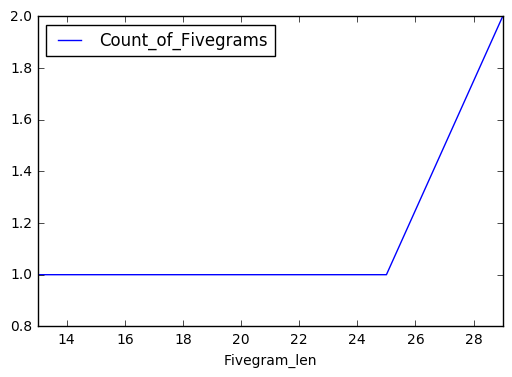

In [27]:

#Plot a histogram
import pandas as pd
import matplotlib.pyplot as plt

#create dict and DF that will hold the counts of the number of fivegrams of each length
fivegram_lengths_list = []
fivegram_counts_list = []


#Add the fivegram lengths and the number of fivegrams of that length to a dict
with open('distribution.txt', 'r') as f:
    for line in f:
        line_list = line.strip("\n").strip("(").strip(")").split(",")
        fivegram_lengths_list.append(int(line_list[0]))
        fivegram_counts_list.append(int(line_list[1]))

#Create a dataframe
fivegram_hist_df = pd.DataFrame({'Fivegram_len':fivegram_lengths_list, 'Count_of_Fivegrams':fivegram_counts_list})

#Sort the dataframe by fivegram length
fivegram_hist_df = fivegram_hist_df.sort_values('Fivegram_len')

#Plot density plot
plt.figure()
fivegram_hist_df.plot(x = 'Fivegram_len', y = 'Count_of_Fivegrams')
plt.show()

__On the full data set:__

## Distribution MRJob stats

__Step 1:__ 

    RUNNING for 157.8s ~= 2.6 minutes  
    Launched map tasks=191  
    Launched reduce tasks=16   
    
__Step 2:__  

    RUNNING for 115.0s ~= 2 minutes   
    Launched map tasks=139
	Launched reduce tasks=1  

In [ ]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("5.3distributions/part-00000").readlines():
    line = line.strip()
    X,Y = line.split(",")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

## 3.  HW5.4.2 <a name="5.4.2"></a>OPTIONAL Question: log-log plots (PHASE 2)
[Back to Table of Contents](#TOC)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

## Example MR stats: (report times!)
    took ~11 minutes on 5 m3.xlarge nodes
    Data-local map tasks=188
	Launched map tasks=190
	Launched reduce tasks=15
	Other local map tasks=2

In [ ]:
# START STUDENT CODE 5.5
# ADD OR REMOVE CELLS AS NEEDED

## NC Outline of Synonym Detection   

Please check for (1) logic and (2) how to parallelize / implement with more than one reducer.

This post is a useful reference
https://ucbischool.slack.com/archives/G5AFVR16J/p1497578722846558

1. Get a list of the 9,000th to 10,000th most common words in the n-grams. These words will be the words by which we will gauge similarity among all other terms. (See this post).
https://ucbischool.slack.com/archives/G5AFVR16J/p1497578747849587
    - This will be tricky to implement with multiple reducers because we need to get a sorted output from multiple partitions. See total sort guide in the 'Resources' folder of the master github repo 
2. Build slightly modified stripes.
    - Modified to only include a word in the stripe if it is one of the 9,000th to 10,000th most common words identified in step 1.  
    - In mapper_init phase, read the list of 9,000th to 10,000th most common words into memory.
    - In the mapper, take each five-gram and loop through all possible pairs of words.
    - Create a dictionary where the keys are each of the five words in the five-gram and the values are dictionaries that contain the other words in the five-gram and the count that comes with the five-gram.
        - This is where the modification happens, we want to create a stripe for each word in the five gram, but only include words in the stripe that have been identified as being the 9,000th to 10,000th most common in step 1 above.
3. Calculate similarity from stripes created in step 2 above.  
    - Should be able to do this just fine with multiple reducers.


#### Stripes Example  

Say we have the following ngram (of the form (ngram) \t (count) \t (pages_count) \t (books_count)):  
A Case Study of Female	447	447	327  

Say that we have identified that the words 'Study' and 'Female' are in the list of the 9,000th to 10,000th most common words across the google five-gram dataset, but the other words in the five-gram are more common than 9,000th - 10,000th.

We would want our stripes output to look like this:  
a  {study:447, female:447}  
case {study:447, female:447}  
study {female:447}  
of {study:447, female:447}  
female {study:447}  
    - Note, all words in the five-gram have a stripe emitted, but only words that are in the list of 9,000th to 10,000th most common words are actually included in those stripes.

### Download a single sample of the google n-grams  

This sample is for testing on local docker container where 

In [ ]:
!wget -O googlebooks-eng-all-5gram-20090715-0-filtered.txt https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACr50woxiBWoaiiLmnwduX8a/googlebooks-eng-all-5gram-20090715-0-filtered.txt?dl=0

### Step 1: Get the 9,001 - 10,000th Words

In [ ]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):

    
    # START STUDENT CODE 5.4.1.B
    def steps(self):
        
        JOBCONF_STEP = {
            'stream.num.map.output.key.fields':2,
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k2,2nr',
            'mapred.reduce.tasks': 1,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        return [
            MRStep(mapper=self.mapper_wc,
                   combiner=self.combiner_wc,
                   reducer=self.reducer_wc),
            MRStep(jobconf=JOBCONF_STEP,
                reducer=self.reducer_sort_phase),
            MRStep(mapper_init=self.mapper_rank_init,
                   mapper=self.mapper_rank)
        ]

    #************************************************    
    #Get word counts
    def mapper_wc(self, _, line):

        #get the list of tokens in the 5-gram
        token_list = line.strip().lower().split()[:-3]

        #emit each token and a 1   
        for token in token_list:
            yield token, 1

    def combiner_wc(self, token, count):
        #just do local sums before passing to reducer
        yield token, sum(count)
            
            
    def reducer_wc(self, token, count):
        yield token, sum(count)
    
    #********************************************************
    #Sort by descending count
    #Reducer sort phase to sort words by descending count
    def reducer_sort_phase(self, word, counts):
        yield word, max(counts)
    
    #********************************************************
    #Rank by word count
    def mapper_rank_init(self):
        self.rank_counter = 0
        
    def mapper_rank(self, word, count):
        self.rank_counter += 1
        
        if (self.rank_counter > 9000) & (self.rank_counter < 10000):
            yield word, None
        else:
            pass
    
    
    # END STUDENT CODE 5.4.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

In [ ]:
#Local works
#!python mostFrequentWords.py -r local googlebooks-eng-all-5gram-20090715-0-filtered.txt > words_9k_10k   

#Hadoop mode for docker container
!python mostFrequentWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > words_9k_10k   

#Hadoop to try in altiscale
#!python mostFrequentWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > words_9k_10k \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload




In [ ]:
!head -20 words_9k_10k

### Step 2: Build Stripes  

Build stripes for all words in n-grams, but the only entries in the stripes are the 9k - 10k words

In [ ]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import collections as cl
import ast

class MRbuildStripes(MRJob):
  
    #START SUDENT CODE531_STRIPES
    
    #OUTPUT_PROTOCOL = JSONValueProtocol
    
    def steps(self):
        
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1',
            'mapreduce.job.reduces': '1'
        }
        
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   reducer=self.reducer
                  )
        ]
    
    def mapper_init(self):
        self.words_9k_10k = open("words_9k_10k").readlines()
        self.words_9k_10k_list = []

        for line in self.words_9k_10k:
            #Add each word to the list
            self.words_9k_10k_list.append(line.split()[0].strip("\""))
 
        #yield self.words_9k_10k_list,None
    def mapper(self, _, line):
        
        #instantiate dict to hold stripes
        stripes_dict = {}
        
        #parse the co-occurrence count from the line
        co_occur_count = line.strip().split()[-3]

        #get pairs of words in the 5-gram and create a stripe for each unique word
        #Note the set here ensures that a word that appears more than once in a 5-gram won't be counted as co-occurring with itself
        #Note the permutations here will count both (word1,word2) and (word2,word1)
        for subset in itertools.permutations(sorted(set(line.strip().lower().split()[:-3])), 2):
            if subset[1].strip("\"") not in self.words_9k_10k_list:
                pass
            
            else:
                if subset[0].strip("\"") not in stripes_dict.keys():
                    stripes_dict[subset[0].strip("\"")] = {}
                    stripes_dict[subset[0].strip("\"")][subset[1].strip("\"")] = int(co_occur_count)

                elif subset[1].strip("\"") not in stripes_dict[subset[0].strip("\"")]:
                    stripes_dict[subset[0].strip("\"")][subset[1].strip("\"")] = int(co_occur_count)

                else:
                    stripes_dict[subset[0].strip("\"")][subset[1].strip("\"")] += int(co_occur_count)
        
        for key in stripes_dict:
            yield key, stripes_dict[key]
            #yield key, json.dumps(stripes_dict[key])
     
    def reducer(self,key,stripe):
        
        #instantiate counter to hold combined stripes
        cur_counter = cl.Counter()
                
        for stripe_dict in stripe:
            cur_key = key
            
            #load the stripe into a dict
            stripe_dict_to_add = stripe_dict
            
            #update with each stripe
            cur_counter.update(stripe_dict_to_add)

        #output the key and the counter with the sum of all co-occurrences for that key
        yield key, cur_counter

    #END SUDENT CODE531_STRIPES

if __name__ == '__main__':
    MRbuildStripes.run()

In [ ]:
#Local works
#!python buildStripes.py -r local --file=words_9k_10k googlebooks-eng-all-5gram-20090715-0-filtered.txt > build_stripes_test   

#Hadoop mode for docker container
!python buildStripes.py -r hadoop --file=words_9k_10k googlebooks-eng-all-5gram-20090715-0-filtered.txt > build_stripes_test   

#Hadoop to try in altiscale
#!python buildStripes.py -r hadoop --file=words_9k_10k googlebooks-eng-all-5gram-20090715-0-filtered.txt > build_stripes_test \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload


In [ ]:
!wc -l build_stripes_test
!head -5 build_stripes_test

### Step 3: Calculate Similarities

In [ ]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
  
    #START SUDENT CODE531_SIMILARITY
    #OUTPUT_PROTOCOL = JSONValueProtocol
    
    def steps(self):
        
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'stream.num.map.output.key.fields': '2',
            'mapreduce.partition.keycomparator.options': '-k1,1',
            'mapreduce.job.reduces': '1'
        }
        
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer
                  )
        ]
    
    def mapper(self, _, line):
        
        #Read the key and the stripe from the input
        key_index_list = line.translate(None,"\n").split("\t")
        
        key = json.loads(key_index_list[0])
        inv_index = json.loads(key_index_list[1])
        
        for subset in itertools.permutations(sorted(set(inv_index.keys())), 2):
            
            #get the lengths of each item that we want to output
            item_1_len = inv_index[subset[0]]
            item_2_len = inv_index[subset[1]]
            
            #create a two item dict to hold the item names and their lengths
            item_len_dict = {}
            item_len_dict[subset[0]] = item_1_len
            item_len_dict[subset[1]] = item_2_len
            
            #when output like this, can index with key[0] to get subset[0] in the reducer
            yield (subset[0], subset[1]), (1,item_len_dict)
  
    def reducer(self, key, stripe):

        #instantiate object to hold the number of times the terms / documents intersect
        items_intersect = 0
        cosine_sim_product = 0
        
        #the reducer gets output from the mapper in chunks grouped by key
        for n,item_len_dict in stripe:
            
            #get the length of item 1 and item 2
            item_1_len = item_len_dict[key[0]]
            item_2_len = item_len_dict[key[1]]
            
            #increment the intersect count
            items_intersect = items_intersect + n
            
            cosine_sim_product = cosine_sim_product + (1/np.sqrt(item_1_len)) * (1/np.sqrt(item_2_len))
            
        #calculate jacard similarity score
        jacard_sim_score = float(items_intersect)/ float(item_1_len + item_2_len - items_intersect)
        
        #Record cosine similarity score before moving on to the next chunk
        cosine_sim_score = cosine_sim_product
        
        yield key, (jacard_sim_score, cosine_sim_score)   
    
    #END SUDENT CODE531_SIMILARITY

if __name__ == '__main__':
    MRsimilarity.run()

In [ ]:
#Local
#!python similarity.py -r local build_stripes_test > similarity_test   

#Hadoop mode for docker container
!python similarity.py -r hadoop build_stripes_test > similarity_test   

#Hadoop to try in altiscale
#!python similarity.py -r hadoop build_stripes_test > similarity_test \
#    --python-bin=./my_env27_for_hadoop_upload/bin/python \
#    --archive=hdfs:///user/nwchen24/virtualenv/my_env27_for_hadoop_upload.zip#my_env27_for_hadoop_upload


In [ ]:
!head -10 similarity_test

print "="*50

!wc -l similarity_test

In [ ]:
# END STUDENT CODE 5.5

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )


In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

## 3.  HW5.6  <a name="5.6"></a> Evaluation of synonyms that your discovered
[Back to Table of Contents](#TOC)


In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [ ]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("sims2/top1000sims","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

## 3.  HW5.7  <a name="5.7"></a> OPTIONAL: using different vocabulary subsets
[Back to Table of Contents](#TOC)


Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

## 3.  HW5.8  <a name="5.8"></a> OPTIONAL: filter stopwords
[Back to Table of Contents](#TOC)

There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



## 3.  HW5.9 <a name="5.9"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## 3.  HW5.10 <a name="5.10"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?